## 头文件和配置

In [1]:
from dnndk import n2cube
import numpy as np
from numpy import float32
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
import matplotlib as mpl
from matplotlib import font_manager
import PowerSensor as ps
from IPython.display import clear_output

mpl.rcParams['axes.unicode_minus']=False     # 正常显示负号
font = font_manager.FontProperties(fname="/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf")

# 一些重要的参数

In [2]:
# 训练用的图像尺寸
img_size_net = 128
# 训练的batch大小
batch_size = 32

wordlist = ['雏菊', '蒲公英', '玫瑰', '向日葵', '郁金香']

# DPU网络参数
# KERNEL_CONV="testModel"
ELF_NAME = "dpu_testModel_0.elf"
CONV_INPUT_NODE = "conv2d_Conv2D"
CONV_OUTPUT_NODE = "y_out_MatMul"

# 测试集读取与测试

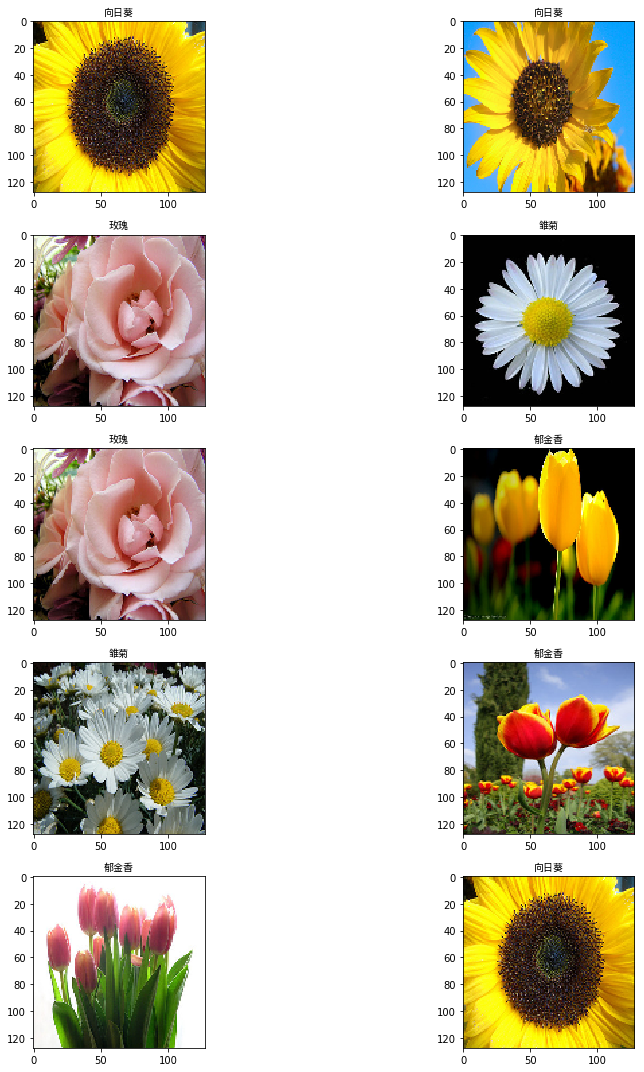

In [3]:
sorts_list = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
img_size_net = 128
calib_batch_size = 50

def load_valid_data(data_path):
    label_cnt = 0
    test_images = []
    test_lables = []
    for sort_path in sorts_list:    
        flower_list = os.listdir(dataset_path + sort_path)
        for img_name in flower_list:
            img_path = dataset_path + sort_path + "/" + img_name
            img = cv2.imread(img_path)  
            img_scale = cv2.resize(img,(img_size_net, img_size_net), interpolation = cv2.INTER_CUBIC)
            if not img is None:
                test_images.append(img_scale / 255.)
                test_lables.append(label_cnt)
        label_cnt += 1             
    return test_images, test_lables

dataset_path = '../dataset_valid/'
(validSet_images, validSet_lables) = load_valid_data(dataset_path)

def calib_input(iter):
    images = []
    for index in range(0, calib_batch_size):
        images.append(validSet_images[index])

    return {CONV_INPUT: images}

# 2. 图像预处理
# test_images = test_images.reshape((-1,28,28,1)) / 255.
validSet_images = np.array(validSet_images, dtype='float32')

# 3. 随机打印8个测试图像
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l = random.randint(0, len(validSet_lables))
        ax[i, j].imshow(cv2.cvtColor(validSet_images[l], cv2.COLOR_BGR2RGB))
        title = wordlist[validSet_lables[l]]
        title_utf8 = title.decode('utf8')
        ax[i, j].set_title(title_utf8, fontproperties=font)
plt.tight_layout()

# 网络模型加载与测试

## 加载模型和获取网络参数

In [4]:
dpu1 = ps.DpuHelper()
dpu1.load_kernel(ELF_NAME, input_node_name=CONV_INPUT_NODE, output_node_name=CONV_OUTPUT_NODE)

INFO:root:DPU: Open dpu!
INFO:root:DPU: load dpu kernel!
INFO:root:DPU: get dpu input64.0,128,128.


## 测试集精度测试

In [5]:
tick_start = time.time()
test_num = len(validSet_lables)
right_eg_cnt = 0
for i in range(test_num):
    img1_scale = validSet_images[i]
    softmax = dpu1.predit_softmax(img1_scale)
    pdt= np.argmax(softmax, axis=0)
    if pdt == validSet_lables[i]:
        right_eg_cnt += 1
tick_end = time.time()
print('精度: ' + str((right_eg_cnt*1.) / test_num))
print('测试 ' + str(test_num) + ' 个样本。耗时 ' + str(tick_end - tick_start) + '秒！')

精度: 1.0
测试 50 个样本。耗时 9.1545650959秒！


## 随机样本预测

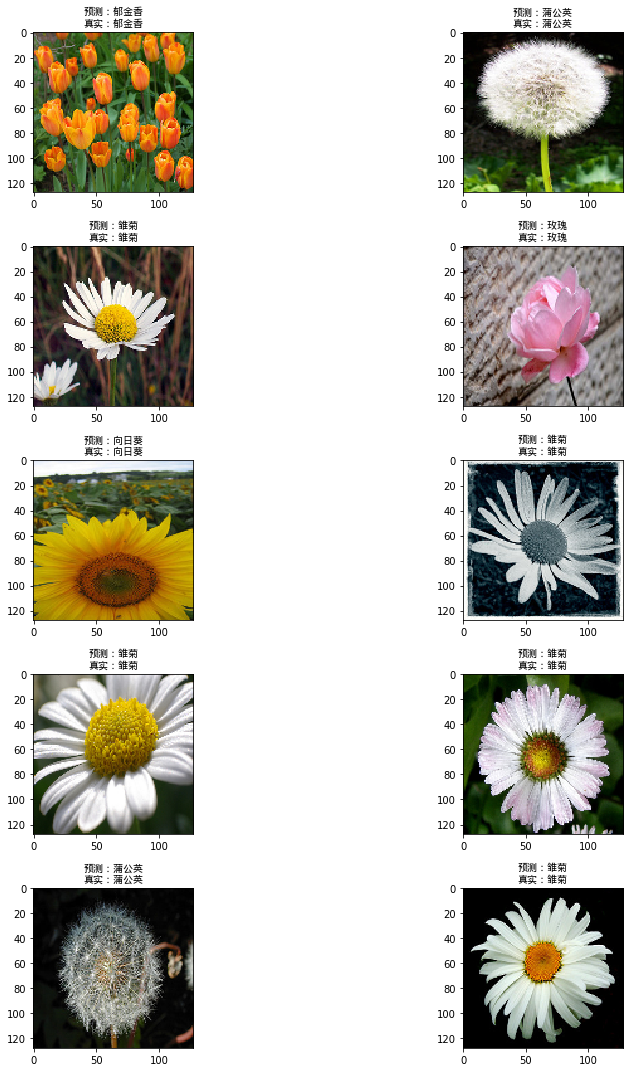

In [6]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l = random.randint(0, len(validSet_lables)-1)
        img1_scale = validSet_images[l]
        softmax = dpu1.predit_softmax(img1_scale)
        pdt= np.argmax(softmax, axis=0)
        ax[i, j].imshow(cv2.cvtColor(validSet_images[l], cv2.COLOR_BGR2RGB))
#         title = "预测：" + str(wordlist[pdt]) + "\n" + "真实：" + str(wordlist[test_labels[l]])
        title = "预测：" + wordlist[pdt] + "\n" + "真实：" + wordlist[validSet_lables[l]]
        title_utf8 = title.decode('utf8')
        ax[i, j].set_title(title_utf8, fontproperties=font)
plt.tight_layout()

## 拍照测试

In [7]:
# 这个对象用于操作摄像头
cam1 = ps.ImageSensor()
cv_font = cv2.freetype.createFreeType2()
cv_font.loadFontData(fontFileName='/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf', id=0)

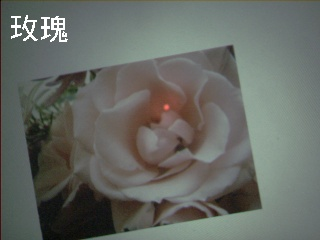

0.277396917343


In [8]:
for i in range(100):
    # 记录时间
    start = time.time()
    # 清空显示区
    clear_output(wait=True)
    # 读取图像
    imgMat = cam1.read_img_ori()
    imgShow = cv2.resize(imgMat, (320,240))
#     imgMat_cali = grey_world2(imgMat)
    # 图像缩放，太大的图像显示非常浪费资源
    tempImg = cv2.resize(imgMat, (128,128))
    img_scale = tempImg / 255.
    img_scale = np.array(img_scale, dtype=np.float32)
    softmax = dpu1.predit_softmax(img_scale)
    pdt= np.argmax(softmax, axis=0)
    cv_font.putText(imgShow,wordlist[pdt], (10,10), fontHeight=30, color=(255,255,255), thickness=-1, line_type=cv2.LINE_4, bottomLeftOrigin=False)
#     tempImg = imgMat
    # 显示图像
    img = ps.CommonFunction.show_img_jupyter(imgShow)
    # 记录运行时间
    end = time.time()
    # 打印运行时间
    print(end - start)
    # 因为网络传输的延时，需要稍息一下
    time.sleep(0.1)